In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
from scipy import linalg
from scipy.interpolate import interp1d

In [2]:
## make the fake data
rich_name = 'q180_bg_miscen'

lam = [20, 30, 45, 60, 1000]
z_data = [0.2, 0.35, 0.5, 0.65]
z_sim = [0.3, 0.4, 0.5]

for iz in range(3):
    
    redshift = z_sim[iz]
    
    if redshift == 0.3: z_str = '0p300'
    if redshift == 0.4: z_str = '0p400'
    if redshift == 0.5: z_str = '0p500'
    
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_{rich_name}_desy1/'
    # get the radius
    rp_list = np.logspace(np.log10(0.03), np.log10(30), 15+1)
    rpmin_list = rp_list[:-1]
    rpmax_list = rp_list[1:]
    rpmid_list = np.sqrt(rpmin_list*rpmax_list)
    rp_rad = rpmid_list[rpmid_list>0.2]
    
    #### lesing data ####
    DS_data = []
    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_lam_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data.extend(np.exp(DS_interp(np.log(rp_rad))))
    DS_data = np.array(DS_data)
    
    #### lensing cov ####
    cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
    for ilam in range(4):    
        rp_cov = np.loadtxt(cov_loc + f'rp_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        
        print('check radius difference', '%.2g'%max(abs(rp_cov[4:]/rp_rad - 1)))
        print(rp_cov[4:])
        print(rp_rad)
        
        data = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        data = data[4:,4:]
        if ilam == 0:
            cov_DS = data * 1.
        else:
            cov_DS = linalg.block_diag(cov_DS, data)
    print('np.shape(cov_DS)', np.shape(cov_DS))
    cov_DS_inv = linalg.inv(cov_DS)
    
    
    #### counts data ####
    x, x, NC_data = np.loadtxt(data_loc+'abundance.dat',unpack=True)
    
    #### counts cov ####
    cov_NC = []
    for ilam in range(4):    
        counts, sv, bias, lnM_mean = np.loadtxt(cov_loc + f'counts_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        cov_NC.append(counts + sv)
    cov_NC = np.diag(cov_NC)
    cov_NC_inv = linalg.inv(cov_NC)
    
    
    #### combine counts and lensing 
    data_vec = np.append(NC_data, DS_data)
    from scipy.linalg import block_diag
    cov = block_diag(cov_NC, cov_DS)
    cov_inv = block_diag(cov_NC_inv, cov_DS_inv)
    
    print('np.shape(cov_inv)', np.shape(cov_inv))
    
    np.savetxt(f'data_vector_abacus_summit/data_vector_{rich_name}_z{redshift}.dat', data_vec)
    np.savetxt(f'data_vector_abacus_summit/cov_inv_z{redshift}.dat', cov_inv)
    np.savetxt(f'data_vector_abacus_summit/cov_z{redshift}.dat', cov)

check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125


FileNotFoundError: /projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/z0p400/model_hod000000/obs_q180_bg_miscen_desy1/DS_phys_noh_lam_bin_0.dat not found.

In [ ]:
# # check radius!
# rp_rad = np.loadtxt(f'/projects/hywu/cluster_sims/cluster_finding/data/emulator_train/train/rp_rad.dat')

# rp_cov = np.loadtxt(cov_loc + 'rp_hiMpc_0.35_0.5_60_1000.dat')[:,2] * a / h
# print((rp_cov[4:] - rp_rad)/rp_rad) #okay!

frac noise: DS [0.09664807 0.08786887 0.08442673 0.08512758 0.09376777 0.11492159
 0.12975851 0.13057233 0.12493822 0.12222172 0.13133058]
frac noise: DS [0.09977092 0.08645702 0.07975671 0.07712015 0.08000827 0.0938234
 0.11094695 0.12091532 0.12418592 0.12791123 0.14027865]
frac noise: DS [0.13008463 0.10829164 0.09593412 0.0896723  0.08945809 0.10080287
 0.12121393 0.14077959 0.15482465 0.16704577 0.18638671]
frac noise: DS [0.10492107 0.082894   0.07014987 0.06305678 0.0599951  0.0644246
 0.0776203  0.09453064 0.11023426 0.12547941 0.14777144]
frac noise: NC [0.04368221 0.07334801 0.1410353  0.23325707]


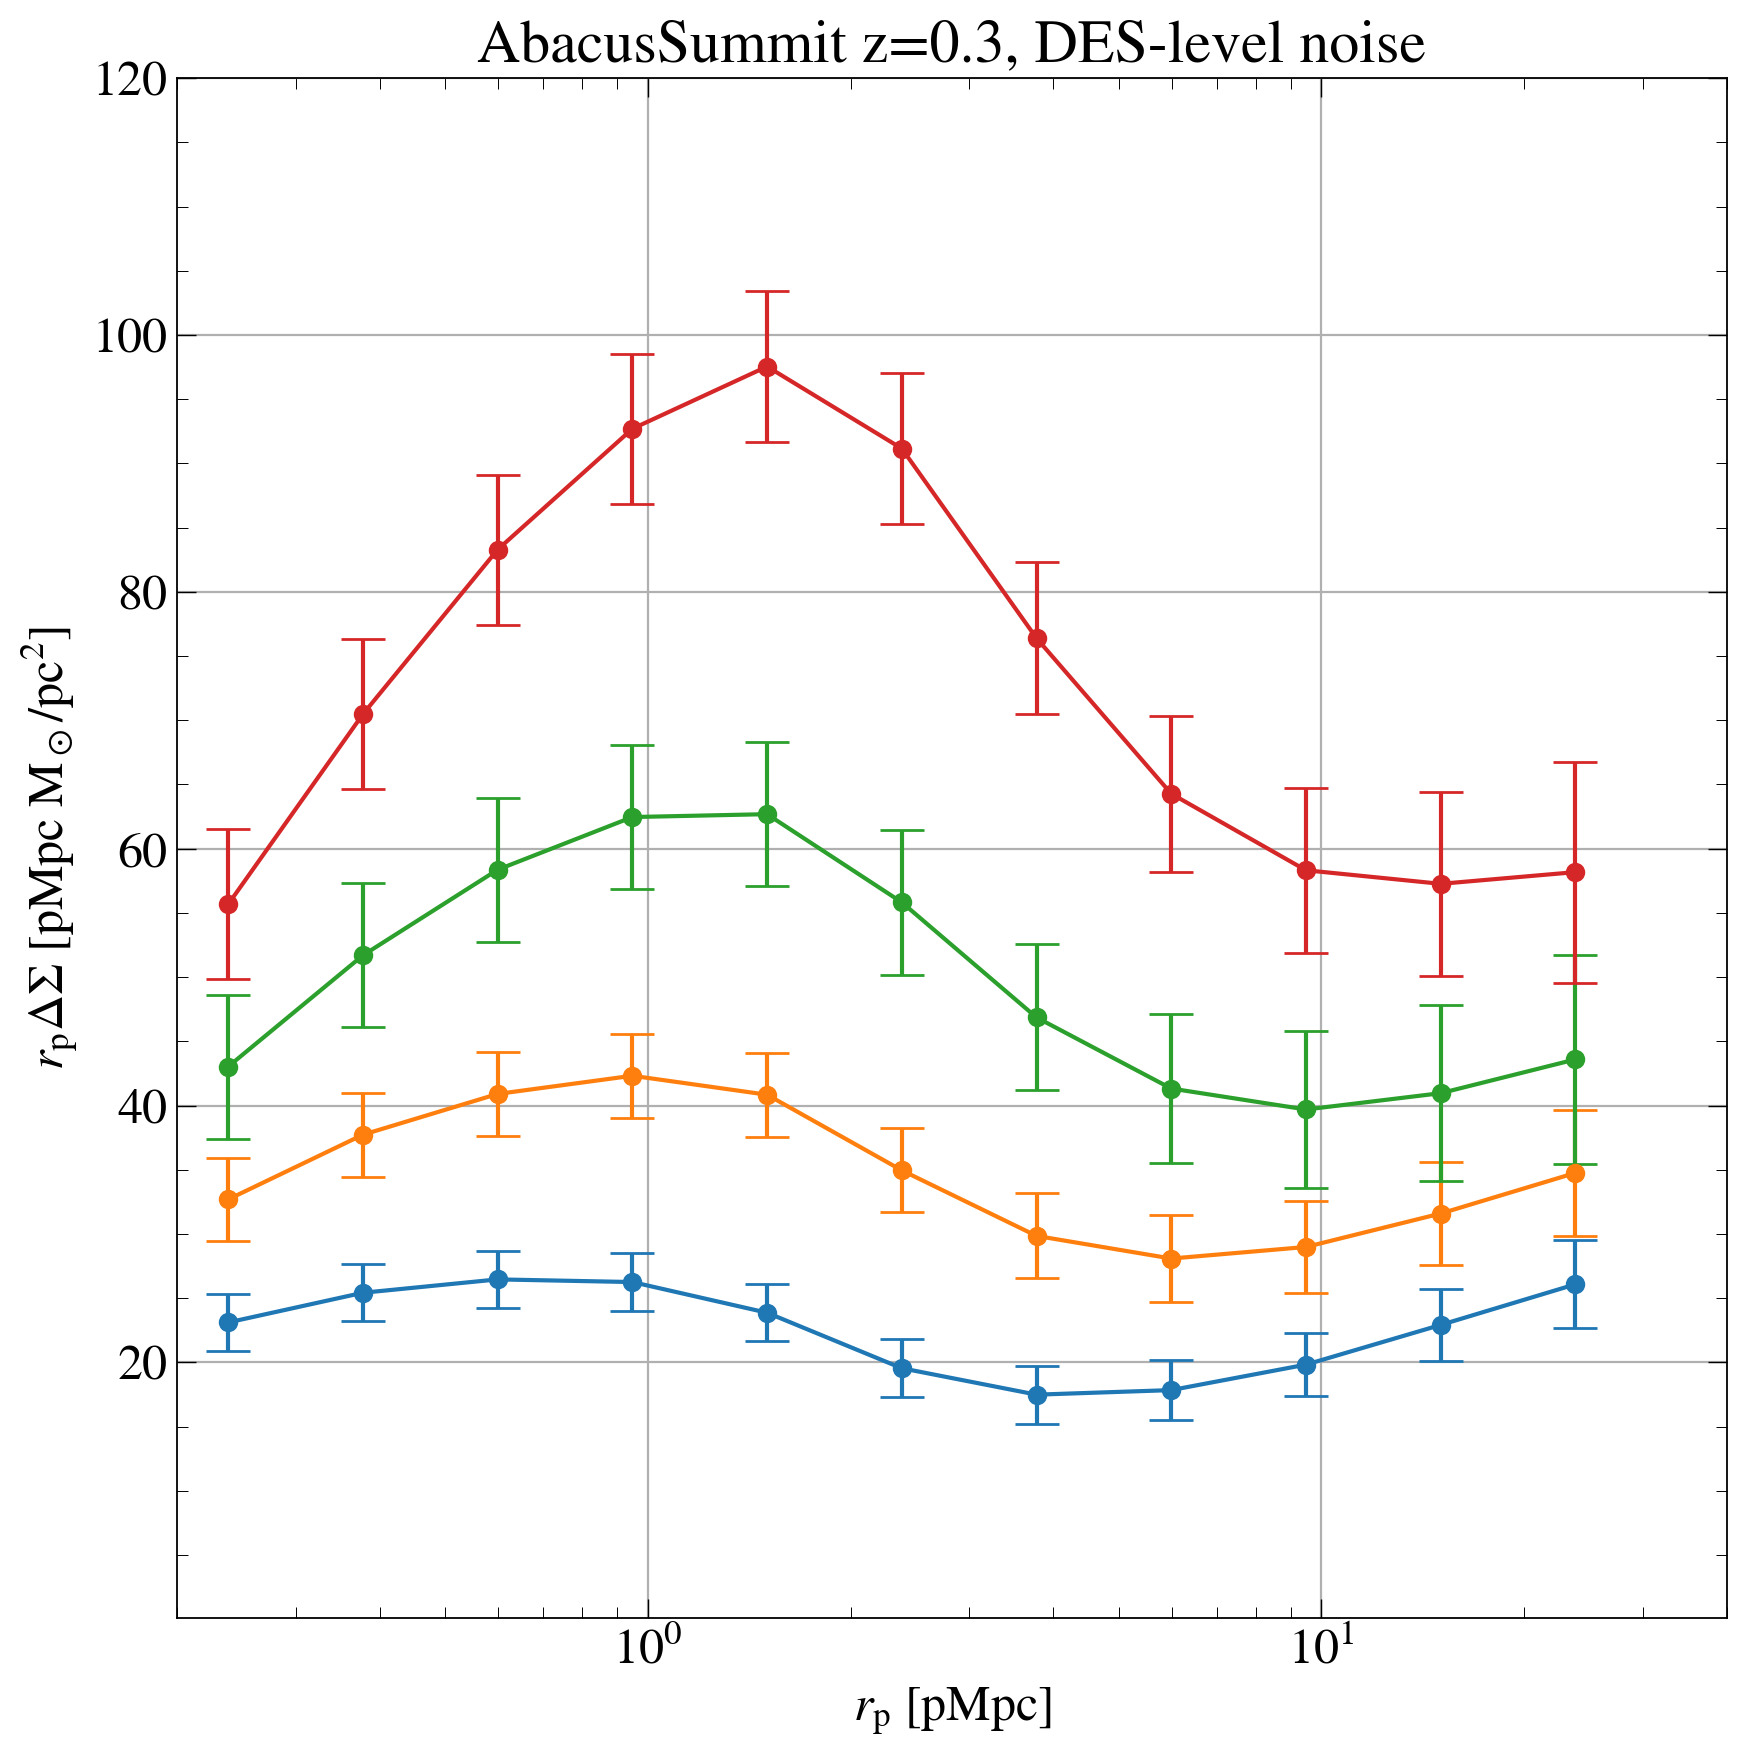

In [5]:
# plot the fake data and error bars
#plt.figure(figsize=(21,7))
plt.figure(figsize=(10,10))
cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
for iz in [0]:#range(3):
    #plt.subplot(1,3,1+iz)
    
    redshift = z_sim[iz]
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_q180_desy1/'

    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_lam_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data = np.exp(DS_interp(np.log(rp_rad)))
    
        cov = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        sig = np.sqrt(np.diag(cov))[4:]
        line = plt.plot(rp_rad, rp_rad*DS_data)
        co = line[0].get_c()
        plt.errorbar(rp_rad, rp_rad*DS_data, rp_rad*sig, 
                     label='data', c=co, marker='o', mec=co, ls='', capsize=8)#, np.diag(cov))
        plt.xscale('log')
        print('frac noise: DS', sig/DS_data)
    
    plt.xlim(0.2, 40)
    plt.ylim(0.10, 120)
    plt.title(f'AbacusSummit z={redshift}, DES-level noise')
    
    plt.xlabel(r'$r_{\rm p}~[{\rm pMpc}]$')
    plt.ylabel(r'$r_{\rm p} \Delta\Sigma~[{\rm pMpc ~M_\odot/pc^2} ]$')
    sig_NC = np.sqrt(np.diag(cov_NC))
    print('frac noise: NC',sig_NC/NC_data)
#plt.savefig(f'../../plots/emulator/abacus_summit_fid_lensing.pdf')